# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 2

In this project, the goal is to design and implement an optimizer. For better understanding, the following mathematical explanations are provided.

The process of learning the parameters $\theta$ of a deep network $f$ with conventional gradient descent algorithms (such as $\texttt{SGD}$) can be represented by the relationship (1) given the training inputs $x$:

\begin{equation}
	\theta_{i+1} = \theta_i - \alpha \nabla f(x; \theta_i)
\end{equation}

Now, if we assume that instead of using a fixed learning rate $\alpha$, we use a function (deep network) such as $g$ with learnable parameters $\phi$, we can rewrite relationship (1) as:

\begin{equation}
	\theta_{i+1} = \theta_i + g(\nabla f(x; \theta_i); \phi)
\end{equation}

Finally, we can also consider the parameter $\theta_i$​ as another input to g and rewrite relationship (2) as follows:
\begin{equation}
	\theta_{i+1} = g(\nabla f(x; \theta_i), \theta_i; \phi)
\end{equation}

It can thus be concluded that if we consider the function $g$ as a recurrent network (such as $\texttt{LSTM}$ or $\texttt{GRU}$), it is possible to present an optimizer, and the entire mentioned process can be carried out with two loops (outer and inner). The architecture of this process is outlined below. Each iteration of the outer loop is equivalent to one epoch for training the network $g$, and each iteration of the inner loop is equivalent to generating one training data for the network $g$.

In this question, the goal is to design and implement an optimizer based on the above explanations:

### Part1:
Consider the first dataset ($\texttt{dataset\_1.csv}$) as the training set, display it (plot it), and then shuffle and divide it into 50 subsets such that each class has an equal number of samples and the selection of samples is done with uniform probability. 
Now, design an arbitrary $\texttt{MLP}$ network and name it $f$ such that $f_1,f_2,f_3,...$ are $\texttt{MLP}$ networks with the same architecture but with different initializations each time.

Next, design a recurrent network based on $\texttt{GRU}$ and name it $g$, whose task is to optimize the learnable weights of the $f$ architecture for the given objective. Using the 50 subsets created in the previous step, train the network g. Explain the implementation process of the training, the designed architecture, and other necessary details completely. 
Note that for each inner loop (in each outer loop), a completely new initialization for the $f$ network takes place. In each subset, the training to testing ratio is 2:8.


### Part2:
Load the second dataset ($\texttt{dataset\_2.csv}$), display it (plot it), and explain the differences between it and the first dataset. Then, divide it into 30 subsets similar to the explanation in part 1. Finally, for each subset, consider a network with the $f$ architecture and optimize it with the $g$ network. Report the average accuracy and error.


### Import libraries

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim

### Check GPU availability

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Read dataset and data visualization

In [58]:
df = pd.read_csv("../inputs/dataset_1.csv")

# shuffling dataset
df = shuffle(df)

# split dataset into the inputs x and the outputs y (labels)
X = df[['x', 'y']]
y = df['label']

print("shape of data frame is:", df.shape)
df

shape of data frame is: (100000, 3)


,x,y,label
86731,-4.27126,-57.73408,1.0
9864,22.81344,-57.07377,1.0
13786,-88.86006,-29.93135,1.0
57450,89.31271,-60.84405,1.0
14618,-51.41234,-53.54308,0.0
...,...,...,...
57012,89.57555,-7.34204,0.0
13672,-20.34214,78.18258,1.0
39343,34.17376,-52.36927,1.0
23302,38.51307,65.93415,1.0


### Convert data to pytorch tensors

In [61]:
X_tensor = torch.tensor(X.values, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y.values, dtype=torch.float32).to(device).view(-1, 1)

print("Training set size:", len(X_tensor))
X_tensor

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Split classes

In [33]:
class0 = torch.cat((X_tensor[y_tensor.flatten() == 0], y_tensor[y_tensor.flatten() == 0]), dim=1)
class1 = torch.cat((X_tensor[y_tensor.flatten() == 1], y_tensor[y_tensor.flatten() == 1]), dim=1)

### Plot dataset

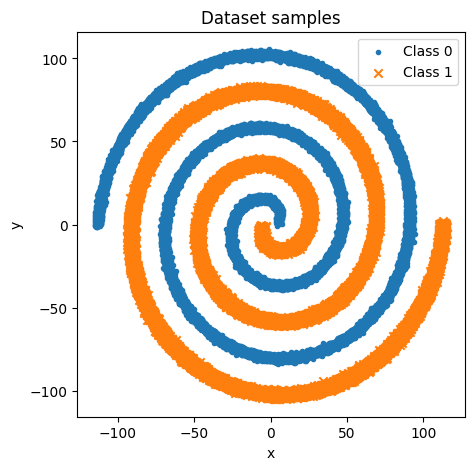

In [34]:
plt.figure(figsize=(5, 5))

plt.scatter(class0[:, 0].cpu().numpy(), class0[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1[:, 0].cpu().numpy(), class1[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

### Split dataset into the 50 subsets

In [35]:
# determine number of samples per subset
num_subsets = 50
num_samples_per_class = min(len(class0), len(class1)) // num_subsets

subsets = []
for _ in range(num_subsets):
    indices_class0 = torch.randperm(len(class0))[:num_samples_per_class]
    indices_class1 = torch.randperm(len(class1))[:num_samples_per_class]
    
    subset_class0 = class0[indices_class0]
    subset_class1 = class1[indices_class1]
    
    subset = torch.cat((subset_class0, subset_class1), dim=0)
    subsets.append(subset)

for i, subset in enumerate(subsets):
    print(f"subset {i+1}: {subset.shape}")

subset 1: torch.Size([2000, 3])
subset 2: torch.Size([2000, 3])
subset 3: torch.Size([2000, 3])
subset 4: torch.Size([2000, 3])
subset 5: torch.Size([2000, 3])
subset 6: torch.Size([2000, 3])
subset 7: torch.Size([2000, 3])
subset 8: torch.Size([2000, 3])
subset 9: torch.Size([2000, 3])
subset 10: torch.Size([2000, 3])
subset 11: torch.Size([2000, 3])
subset 12: torch.Size([2000, 3])
subset 13: torch.Size([2000, 3])
subset 14: torch.Size([2000, 3])
subset 15: torch.Size([2000, 3])
subset 16: torch.Size([2000, 3])
subset 17: torch.Size([2000, 3])
subset 18: torch.Size([2000, 3])
subset 19: torch.Size([2000, 3])
subset 20: torch.Size([2000, 3])
subset 21: torch.Size([2000, 3])
subset 22: torch.Size([2000, 3])
subset 23: torch.Size([2000, 3])
subset 24: torch.Size([2000, 3])
subset 25: torch.Size([2000, 3])
subset 26: torch.Size([2000, 3])
subset 27: torch.Size([2000, 3])
subset 28: torch.Size([2000, 3])
subset 29: torch.Size([2000, 3])
subset 30: torch.Size([2000, 3])
subset 31: torch.Si

### Print sub datasets

In [36]:
for i, loader in enumerate(subsets):
    print(f"Subset {i+1}:")
    print(loader)
    print('-' * 50)

Subset 1:
tensor([[-108.1133,   21.9453,    0.0000],
        [ -25.8561,   -8.8516,    0.0000],
        [  85.1983,  -20.1019,    0.0000],
        ...,
        [ -89.9088,  -23.2288,    1.0000],
        [ -37.9117,  -35.2950,    1.0000],
        [  91.7530,  -58.6858,    1.0000]], device='cuda:0')
--------------------------------------------------
Subset 2:
tensor([[-25.7408, 100.5094,   0.0000],
        [ 62.2158,  75.2354,   0.0000],
        [ -0.3676, 101.8952,   0.0000],
        ...,
        [-74.8565,  45.4350,   1.0000],
        [-68.4939, -65.3940,   1.0000],
        [ 99.1503, -49.6216,   1.0000]], device='cuda:0')
--------------------------------------------------
Subset 3:
tensor([[-100.0346,   47.7822,    0.0000],
        [  84.8021,  -26.5260,    0.0000],
        [ -16.1543,  -76.8326,    0.0000],
        ...,
        [  33.9310,   70.4512,    1.0000],
        [   6.9071,   76.7631,    1.0000],
        [  70.8494,    5.6559,    1.0000]], device='cuda:0')
-------------------

### Design MLP network

* Input layer: 2 neurons
* Hidden layer1: 128 neurons
* Hidden layer2: 64 neurons
* output layer: 1 neurons
* Activation function: ReLU

In [37]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Create 50 instances of the MLP network with different initializations

In [38]:
num_networks = 50
networks = [MLP().to(device) for _ in range(num_networks)]
networks

[MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=1, bias=True)
   (relu): ReLU()
 ),
 MLP(
   (fc1): Linear(in_features=2, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=64, bias=True)
   (fc3): Linear(in_feature

### Define the GRU-based RNN (G)

In [39]:
class GRUOptimizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUOptimizer, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

### Initialize the GRU optimizer network

In [40]:
input_size = 1
hidden_size = 128
output_size = 1
gru_optimizer = GRUOptimizer(input_size, hidden_size, output_size).to(device)

optimizer_gru = optim.Adam(gru_optimizer.parameters(), lr=0.001)
criterion = nn.MSELoss()

### Training phase

In [41]:
for subset in subsets:

    # split subset into training and testing sets with 2:8 ratio
    subset = subset.cpu().numpy()
    train_size = int(0.2 * len(subset))
    train_data, test_data = train_test_split(subset, train_size=train_size, random_state=42)
    
    train_data = torch.tensor(train_data, dtype=torch.float32).to(device)
    test_data = torch.tensor(test_data, dtype=torch.float32).to(device)
    
    train_X, train_y = train_data[:, :2], train_data[:, 2].view(-1, 1)
    test_X, test_y = test_data[:, :2], test_data[:, 2].view(-1, 1)
    
    # outer loop
    for _ in range(10):
        f = MLP().to(device)
        optimizer_f = optim.SGD(f.parameters(), lr=0.01)
        
        hidden = None
        # inner loop
        for epoch in range(5):
            optimizer_f.zero_grad()
            
            # forward pass
            outputs = f(train_X)
            loss = criterion(outputs, train_y)
            
            # backward pass
            loss.backward()
            
            # get the gradients
            gradients = []
            for param in f.parameters():
                gradients.append(param.grad.view(-1))
            gradients = torch.cat(gradients).view(1, -1, 1).to(device)
            
            # update the parameters using the GRU optimizer
            updates, hidden = gru_optimizer(gradients, hidden)
            updates = updates.view(-1)
            
            # apply the updates to the parameters
            with torch.no_grad():
                for param, update in zip(f.parameters(), updates):
                    param -= 0.01 * update  # learning rate could be adjusted
            
            # zero the gradients after updating
            for param in f.parameters():
                param.grad = None
        
        # evaluate network testing set data
        f.eval()
        with torch.no_grad():
            outputs = f(test_X)
            test_loss = criterion(outputs, test_y)
            print(f"Test Loss: {test_loss.item()}")

Test Loss: 5.063145637512207
Test Loss: 27.1988525390625
Test Loss: 100.13819885253906
Test Loss: 24.232324600219727
Test Loss: 9.94677448272705
Test Loss: 8.841064453125
Test Loss: 86.9176254272461
Test Loss: 6.941280364990234
Test Loss: 23.642824172973633
Test Loss: 60.91307067871094
Test Loss: 86.80789947509766
Test Loss: 11.514041900634766
Test Loss: 11.194198608398438
Test Loss: 5.793320178985596
Test Loss: 2.8445591926574707
Test Loss: 14.99842357635498
Test Loss: 12.3972749710083
Test Loss: 75.70719146728516
Test Loss: 18.007768630981445
Test Loss: 24.93187713623047
Test Loss: 24.820404052734375
Test Loss: 11.797712326049805
Test Loss: 30.196996688842773
Test Loss: 19.29627227783203
Test Loss: 9.756349563598633
Test Loss: 59.93244934082031
Test Loss: 67.55325317382812
Test Loss: 26.383913040161133
Test Loss: 37.92388916015625
Test Loss: 22.399011611938477
Test Loss: 9.648382186889648
Test Loss: 5.5600128173828125
Test Loss: 10.303197860717773
Test Loss: 25.548847198486328
Test L

## Part 2:

### Read and Plot dataset 2

In [42]:
df_2 = pd.read_csv("../inputs/dataset_2.csv")

# shuffling dataset
df_2 = shuffle(df_2)

# split dataset into the inputs x and the outputs y (labels)
X_2 = df_2[['x', 'y']]
y_2 = df_2['label']

print("shape of data frame is:", df_2.shape)
df_2

shape of data frame is: (60000, 3)


,x,y,label
41177,25.69570,72.56105,1.0
51613,64.27368,34.96430,1.0
11974,-26.33820,55.62602,0.0
52064,-46.20564,0.49881,1.0
35444,20.06251,73.49030,1.0
...,...,...,...
39690,89.57540,-17.14137,0.0
49475,-37.00959,-36.36823,1.0
42266,7.73466,79.56765,1.0
28863,8.24539,79.49185,1.0


In [43]:
X2_tensor = torch.tensor(X_2.values, dtype=torch.float32).to(device)
y2_tensor = torch.tensor(y_2.values, dtype=torch.float32).to(device).view(-1, 1)

print("Training set size:", len(X2_tensor))
X2_tensor

Training set size: 60000


tensor([[ 25.6957,  72.5611],
        [ 64.2737,  34.9643],
        [-26.3382,  55.6260],
        ...,
        [  7.7347,  79.5676],
        [  8.2454,  79.4919],
        [ 79.8586, -33.7253]], device='cuda:0')

In [44]:
class0_2= torch.cat((X2_tensor[y2_tensor.flatten() == 0], y2_tensor[y2_tensor.flatten() == 0]), dim=1)
class1_2 = torch.cat((X2_tensor[y2_tensor.flatten() == 1], y2_tensor[y2_tensor.flatten() == 1]), dim=1)

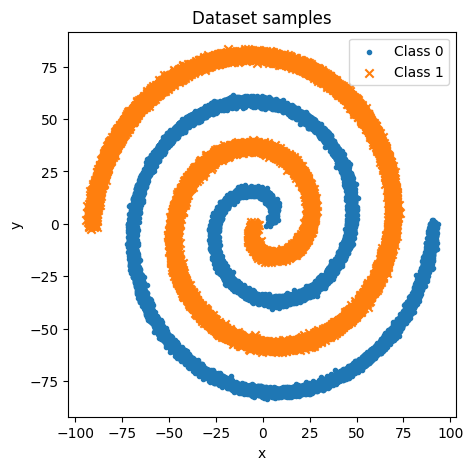

In [45]:
plt.figure(figsize=(5, 5))

plt.scatter(class0_2[:, 0].cpu().numpy(), class0_2[:, 1].cpu().numpy(), label="Class 0", marker='.')
plt.scatter(class1_2[:, 0].cpu().numpy(), class1_2[:, 1].cpu().numpy(), label="Class 1", marker='x')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Dataset samples")
plt.legend()

plt.show()

### Divide into 30 Subsets

In [47]:
# Number of subsets
num_subsets_2 = 30

# Divide into subsets
subsets_2 = []

for i in range(num_subsets_2):
    subset = df_2.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), len(df_2) // num_subsets_2 // len(df_2['label'].unique()))))
    subsets_2.append(subset)

# Verify the subsets
for i, subset in enumerate(subsets_2):
    print(f"Subset {i+1}:")
    print(subset['label'].value_counts())


Subset 1:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 2:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 3:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 4:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 5:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 6:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 7:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 8:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 9:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 10:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 11:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 12:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 13:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 14:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subset 15:
label
0.0    1000
1.0    1000
Name: count, dtype: int64
Subs

/tmp/ipykernel_12110/1469251918.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset = df_2.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), len(df_2) // num_subsets_2 // len(df_2['label'].unique()))))
/tmp/ipykernel_12110/1469251918.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset = df_2.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), len(df_2)

In [53]:
# Create data loaders for the subsets
subset_loaders_2 = []
for subset in subsets_2:
    X = torch.tensor(subset[['x', 'y']].values, dtype=torch.float32).to(device)
    y = torch.tensor(subset['label'].values, dtype=torch.float32).to(device).view(-1, 1)
    dataset = TensorDataset(X, y)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)
    subset_loaders_2.append(loader)

# Define evaluation function
def evaluate_model(f, data_loader):
    correct = 0
    total = 0
    criterion = nn.BCEWithLogitsLoss()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = f(X_batch)
            loss = criterion(outputs, y_batch)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    accuracy = 100 * correct / total
    error = loss.item()
    return accuracy, error

accuracies = []
errors = []

# Assuming `g` is already trained and loaded
optimizer_hidden_size = 100  # Example hidden size for the optimizer

# Loop through each subset and optimize using `g`
for loader in subset_loaders_2:
    # Initialize a new MLP network `f` for each subset
    f = MLP().to(device)
    h = torch.zeros(1, optimizer_hidden_size).to(device)

    # Training loop for `f`
    num_epochs_f = 5  # Example epoch count
    criterion = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs_f):
        for X_batch, y_batch in loader:
            outputs = f(X_batch)
            loss = criterion(outputs, y_batch)
            
            f.zero_grad()
            loss.backward()

            for param in f.parameters():
                grad = param.grad.data
                grad_flat = grad.view(-1, 1)
                grad_cat = torch.cat((grad_flat, param.data.view(-1, 1)), dim=1)
                
                update, h = g(grad_cat, h)
                param.data -= update.view(param.data.size())

    # Evaluate the model
    accuracy, error = evaluate_model(f, loader)
    accuracies.append(accuracy)
    errors.append(error)

# Report the average accuracy and error
avg_accuracy = sum(accuracies) / len(accuracies)
avg_error = sum(errors) / len(errors)

print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average Error: {avg_error:.4f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
